### ELV Assignment 1
[Reference Paper](https://www.pnas.org/doi/10.1073/pnas.1802705116)  
[Reference video 1](https://youtu.be/9GkxEEqEGhg?si=eSbcXl5bgqmUorJJ)  
[Reference video 2](https://www.youtube.com/watch?v=hEGGa8y5_wM)  
[pythonspeed](https://pythonspeed.com/)


![Fig 2 from paper](fig2.png)


* Hard Phases
* What is Information theoretically possible
* Write about GAMP
* LR does'nt have prior info about the fact that the weights are binary unlike the AMP algorithm

#### PROBLEMS:
* Interpreting different random seed's effect
* Why is there not a direct correspondance with the plot from the paper
* is regularisation good enough
* effect of increasing D
* should we try for larger alpha range (to see if there's any phase transition)
* consider implementing more optimisations
* LR might struggle with high D, why and how to fix

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import gc

def run_experiment(D=10000, teacher_seed=42):
    # Step 1: Generate teacher model (with random binary weights)
    # we do some things to be able to generate data for large D without memory issues
    np.random.seed(teacher_seed) 
    w_teacher = np.random.choice([1, -1], size=D) # arr of size D with +-1 

    # Step 2: Generate dataset
    N_total = int(2.2 * D)  # 2D (train) + 0.2D (test)
    print('wgenerated')
    X = np.random.randn(N_total, D)  
    print(X.shape,w_teacher.shape)
    y = np.sign(X@(w_teacher))  # labels {+1,-1} 
    y[y == 0] = 1  # Replace any 0s with 1
    del w_teacher
    gc.collect()
    print('X,y computed')
    # Split dataset into test and train
    X_train, X_test = X[:2*D], X[2*D:]
    y_train, y_test = y[:2*D], y[2*D:]
    del X, y
    gc.collect() 
    # Define range of α values
    print("success, test train split done")
    alphas = np.arange(0.2, 2.2, 0.2) # [0.2,0.4...2]
    test_errors = []

    # Precompute hyperparameter grid for Logistic Regression
    Cs = np.logspace(-4, 6, 15) 

    for alpha in alphas:
        n = int(alpha * D)
        X_subset = X_train.view()[:n] # prevent array copying
        y_subset = y_train.view()[:n]

        # Train Logistic Regression with cross-validation
        model = LogisticRegressionCV(
            Cs=Cs, cv=4, penalty='l2', solver='saga',
            max_iter=100000, tol=1e-3, random_state=teacher_seed, n_jobs=-1
        )
        model.fit(X_subset, y_subset)
        y_pred = model.predict(X_test)

        # Compute classification error (misclassification rate)
        test_error = np.mean(np.square(y_test-y_pred)) 
        test_errors.append(test_error)

        #print(f"Alpha={alpha:.1f}, Error={test_error:.4f}")

    return alphas, test_errors

def plot_results(alphas, errors_list, labels, D,name):
    plt.figure(figsize=(10, 6))
    for errors, label in zip(errors_list, labels):
        plt.plot(alphas, errors, 'o-', label=label)
    plt.xlabel('Sample Complexity (α)')
    plt.ylabel('Test Error')
    plt.title(f'Generalization Error vs α (D={D})')
    plt.grid(True)
    plt.ylim(0,)
    plt.legend()

    # Save figure 
    filename = f'generalization_error_D{D}_{name}.png'
    plt.savefig(filename)
    plt.show()

    print(f"Plot saved as {filename}")

# Experiment: Run with different teacher seeds
# This will fail for large D (especially due to memory issues) -> fix using batches, torch blah blah
D = int(1e4) # dimensionality   
teacher_seed1,teacher_seed2 = 42,2004

alphas, errors1 = run_experiment(D=D, teacher_seed=teacher_seed1)
_, errors2 = run_experiment(D=D, teacher_seed=teacher_seed2)
#plot_results(alphas, [errors1, errors2], [f'Teacher 1, seed = {teacher_seed1}', f'Teacher 2, seed = {teacher_seed2}'], D=D,name='combined')
#plot_results(alphas, [errors1], [f'seed = {teacher_seed1}'], D=D,name = 'teacher 1')
#plot_results(alphas, [errors2], [f'seed = {teacher_seed2}'], D=D,name = 'teacher 2')

wgenerated
(22000, 10000) (10000,)
X,y computed
success, test train split done
wgenerated
(22000, 10000) (10000,)
X,y computed
success, test train split done


In [21]:
import jax.numpy as jnp
from jax import jit, random
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import psutil
from sklearn.linear_model import LogisticRegressionCV
import multiprocessing as mp

# Ensure safe multiprocessing
try:
    mp.set_start_method('spawn', force=True)
except RuntimeError:
    pass

def log_resource_usage():
    memory = psutil.virtual_memory()
    print(f"Memory Usage: {memory.percent}% | Available: {memory.available / (1024**3):.2f} GB")
    
def calculate_optimal_batch_size(D):
    available_memory_gb = psutil.virtual_memory().available / (1024**3)
    max_memory_usage_gb = available_memory_gb * 0.8  # Use 80% of available memory
    estimated_batch_size_gb = D * 4 / (1024**3)  # Assuming float32 (4 bytes per value)
    optimal_batch_size = int(max_memory_usage_gb / estimated_batch_size_gb * 1e4)
    return max(1000, min(optimal_batch_size, int(1e4)))


def generate_data(D=10000, teacher_seed=42,alpha_min = 0.2, alpha_max=2):
    try:
        key = random.PRNGKey(teacher_seed)
        w_teacher = random.choice(key, jnp.array([1, -1]), shape=(D,))

        N_total = int((alpha_max+alpha_min) * D)
        print('Creating memory-mapped data...')
        X = np.memmap('X_data.dat', dtype='float16', mode='w+', shape=(N_total, D))
        y = np.memmap('y_data.dat', dtype='int8', mode='w+', shape=(N_total,))

        batch_size = calculate_optimal_batch_size(D)
        num_batches = (N_total + batch_size - 1) // batch_size
        key = random.split(key, num_batches)

        @jit
        def process_batch(subkey, w_teacher):
            X_batch = random.normal(subkey, (batch_size, D)).astype(jnp.float16)
            y_batch = jnp.sign(X_batch @ w_teacher)
            y_batch = jnp.where(y_batch == 0, 1, y_batch)
            return X_batch, y_batch

        for i in range(num_batches):
            start = i * batch_size
            end = min((i + 1) * batch_size, N_total)
            current_batch_size = end - start
            print(f"Processing batch {start}-{end}")
            log_resource_usage()
            X_batch, y_batch = process_batch(key[i], w_teacher)
            X[start:end] = np.asarray(X_batch[:current_batch_size])
            y[start:end] = np.asarray(y_batch[:current_batch_size])

        del w_teacher, key,X_batch,y_batch
        gc.collect()
        print("Data generation completed.")

    except MemoryError:
        print("MemoryError: Reduce D or batch size to avoid memory overflow.")
        exit()



def plot_results(alphas, errors_list, labels, D, name):
    plt.figure(figsize=(10, 6))
    for errors, label in zip(errors_list, labels):
        plt.plot(alphas, errors, 'o-', label=label)
    plt.xlabel('Sample Complexity (α)')
    plt.ylabel('Test Error')
    plt.title(f'Generalization Error vs α (D={D})')
    plt.grid(True)
    plt.ylim(0,)
    plt.legend()

    os.makedirs('./figures', exist_ok=True)
    filename = f'./figures/generalization_error_D{D}_{name}.png'
    plt.savefig(filename)

    plt.show()
    print(f"Plot saved as {filename}")


In [22]:
D = int(1e4)
alpha_min,alpha_max,alpha_step = 1,15,1
teacher_seed1, teacher_seed2 = 42, 2004

two_teachers = (D<=1e4) # change this lol 

generate_data(D=D, teacher_seed=teacher_seed1,alpha_max=alpha_max,alpha_min=alpha_min)


Creating memory-mapped data...
Processing batch 0-10000
Memory Usage: 32.8% | Available: 10.76 GB
Processing batch 10000-20000
Memory Usage: 33.6% | Available: 10.62 GB
Processing batch 20000-30000
Memory Usage: 34.1% | Available: 10.54 GB
Processing batch 30000-40000
Memory Usage: 34.1% | Available: 10.54 GB
Processing batch 40000-50000
Memory Usage: 34.1% | Available: 10.54 GB
Processing batch 50000-60000
Memory Usage: 34.1% | Available: 10.54 GB
Processing batch 60000-70000
Memory Usage: 34.1% | Available: 10.54 GB
Processing batch 70000-80000
Memory Usage: 34.2% | Available: 10.53 GB
Processing batch 80000-90000
Memory Usage: 34.2% | Available: 10.53 GB
Processing batch 90000-100000
Memory Usage: 34.2% | Available: 10.53 GB
Processing batch 100000-110000
Memory Usage: 34.2% | Available: 10.53 GB
Processing batch 110000-120000
Memory Usage: 34.4% | Available: 10.50 GB
Processing batch 120000-130000
Memory Usage: 34.4% | Available: 10.50 GB
Processing batch 130000-140000
Memory Usage

Memory Usage: 62.5% | Available: 5.99 GB
Memory Usage: 59.9% | Available: 6.41 GB
Memory Usage: 57.8% | Available: 6.76 GB
Memory Usage: 53.6% | Available: 7.43 GB
Memory Usage: 44.4% | Available: 8.89 GB
Memory Usage: 37.3% | Available: 10.04 GB
Memory Usage: 29.2% | Available: 11.33 GB
Memory Usage: 29.1% | Available: 11.34 GB
Memory Usage: 26.9% | Available: 11.69 GB
Memory Usage: 25.6% | Available: 11.90 GB
Memory Usage: 27.2% | Available: 11.65 GB
Memory Usage: 30.1% | Available: 11.18 GB
Memory Usage: 22.1% | Available: 12.46 GB
Memory Usage: 29.9% | Available: 11.21 GB
Memory Usage: 27.3% | Available: 11.63 GB


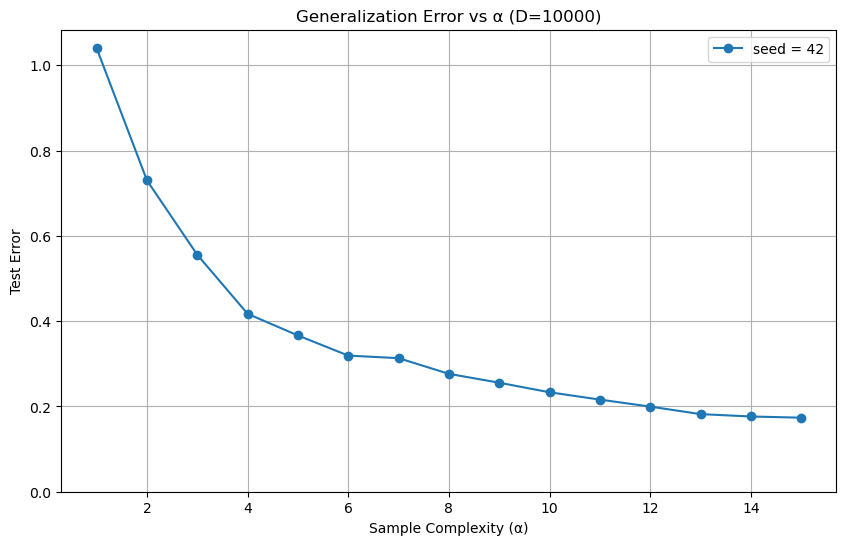

Plot saved as ./figures/generalization_error_D10000_plot.png


In [19]:
def run_experiment(D=10000, teacher_seed=42,alpha_max=2,alpha_min=0.2,alpha_step=0.2):
    try:
        N_total = int((alpha_max+alpha_min) * D)
        X = np.memmap('X_data.dat', dtype='float16', mode='r', shape=(N_total, D))
        y = np.memmap('y_data.dat', dtype='int8', mode='r', shape=(N_total,))

        X_train = X[:(alpha_max) * D]
        X_test = X[(alpha_max) * D:]
        y_train = y[:(alpha_max)* D]
        y_test = y[(alpha_max)* D:]

        alphas = np.arange(alpha_min,alpha_max+alpha_min, alpha_step)
        #alphas = np.arange(0.2,2.2, 0.2)
        test_errors = []

        Cs = np.logspace(-4, 4, 5)

        for alpha in alphas:
            n = int(alpha * D)
            X_subset = X_train[:n]
            y_subset = y_train[:n]

            log_resource_usage()
            model = LogisticRegressionCV(
                Cs=Cs, cv=3, penalty='l2', solver='lbfgs',
                max_iter=int(1e6), tol=1e-3, random_state=teacher_seed
            )
            model.fit(X_subset, y_subset)
            y_pred = model.predict(X_test)

            test_error = np.mean(np.square(y_test - y_pred))
            # test_error = 4 * (#misclassified samples/ #samples)  
            test_errors.append(float(test_error))
            del model, y_pred
            gc.collect()  

        return alphas, test_errors

    except MemoryError:
        print("MemoryError: Reduce D or adjust solver options to reduce memory usage.")
        exit()


alphas, errors1 = run_experiment(D=D, teacher_seed=teacher_seed1,alpha_max=alpha_max,alpha_min=alpha_min,alpha_step=alpha_step)
two_teachers = False
if(two_teachers):
    generate_data(D=D, teacher_seed=teacher_seed2)
    _, errors2 = run_experiment(D=D, teacher_seed=teacher_seed2)

    plot_results(alphas, [errors1, errors2], [f'Teacher 1, seed = {teacher_seed1}', f'Teacher 2, seed = {teacher_seed2}'], D=D, name='combined')
    plot_results(alphas, [errors1], [f'Teacher 1, seed = {teacher_seed1}'], D=D, name='teacher 1')
    plot_results(alphas, [errors2], [f'Teacher 2, seed = {teacher_seed2}'], D=D, name='teacher 2')
else:
    plot_results(alphas, [errors1], [f'seed = {teacher_seed1}'], D=D, name='plot')

#os.remove('X_data.dat')
#os.remove('y_data.dat')

# note: D=1e4 : took <2mins to run exp ; but D=5e4 took ~ 60 mins, but worse off err ~ 2 for all alpha (misclassifying all?)